In [2]:
%reset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate

from quantum_systems import ODQD, GeneralOrbitalSystem

In [4]:
l = 10  # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 2001  # The number of discretized points on the grid.
# More points give better results for the single-particle basis at the cost of slower setup.

alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential

omega = 0.25  # The frequency of the harmonic oscillator trap

potential=ODQD.HOPotential(omega)

odho = ODQD(l, grid_length, num_grid_points, a=a, alpha=alpha, potential=potential )

print(f"l = {odho.l}")
print(f"grid shape = {odho.grid.shape}")
print(f"h shape = {odho.h.shape}")
print(f"u shape = {odho.u.shape}")
print(f"x shape = {odho.position.shape}")
print(f"spf shape = {odho.spf.shape}")

l = 10
grid shape = (2001,)
h shape = (10, 10)
u shape = (10, 10, 10, 10)
x shape = (1, 10, 10)
spf shape = (10, 2001)


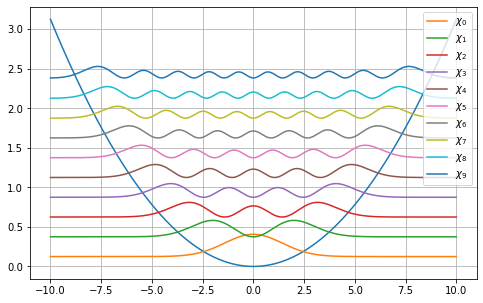

In [5]:
fig = plt.figure(figsize=(8, 5))

plt.plot(odho.grid, potential(odho.grid))

for i in range(l):
    plt.plot( odho.grid, np.abs(odho.spf[i]) ** 2 + odho.h[i, i].real, label=r"$\chi_{" + f"{i}" + r"}$" )

plt.grid()
plt.legend()
plt.show()

In [6]:
nparticles = 2
system = GeneralOrbitalSystem(n=nparticles, basis_set=odho, anti_symmetrize = True)

print(f"l = {system.l}")
print(f"grid shape = {system._basis_set.grid.shape}")
print(f"h shape = {system.h.shape}")
print(f"u shape = {system.u.shape}")
print(f"x shape = {system.position.shape}")
print(f"spf shape = {system.spf.shape}")

l = 20
grid shape = (2001,)
h shape = (20, 20)
u shape = (20, 20, 20, 20)
x shape = (1, 20, 20)
spf shape = (20, 2001)


In [7]:
f = np.zeros( system.h.shape )
density = np.zeros( (l,l) )
u_hf = np.zeros( system.u.shape )

for i in range(nparticles*l):
    for j in range(nparticles*l):
        for p in range(nparticles*l):
            for q in range(nparticles*l):
                u_hf[i,j,p,q] = system.u[i,j,p,q] - system.u[i,j,q,p]

<ipython-input-7-b84ebe171bea>:9: ComplexWarning: Casting complex values to real discards the imaginary part
  u_hf[i,j,p,q] = system.u[i,j,p,q] - system.u[i,j,q,p]


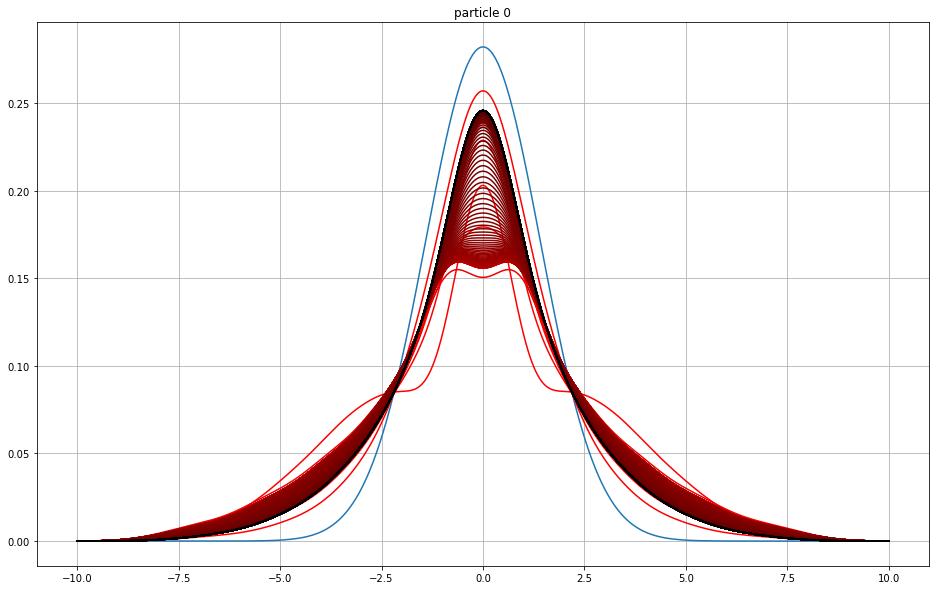

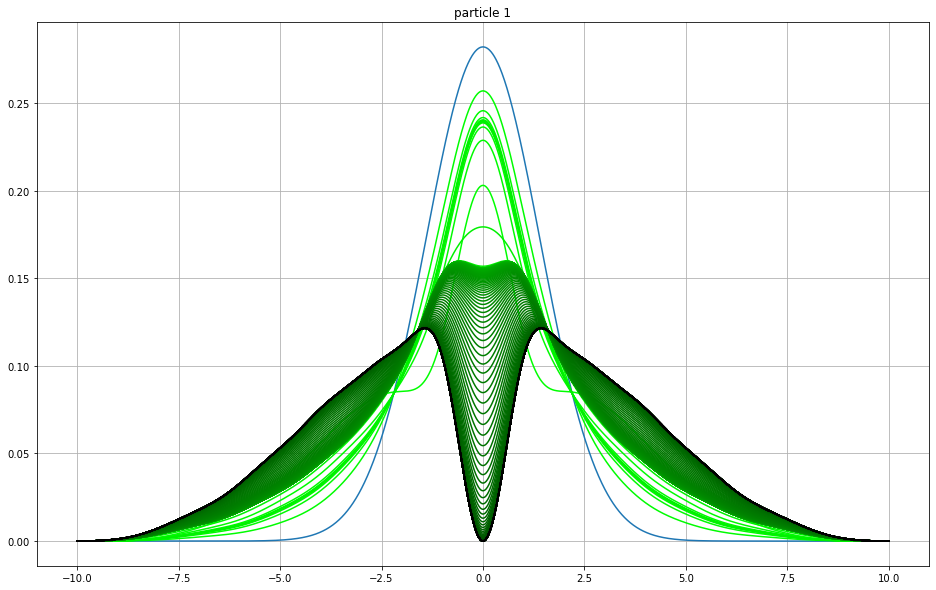

In [43]:
tolerance = 1e-8

#FIRST RUN WITHOUT PLOT
eigenv, eigenst = scipy.linalg.eig(system.h)
E_old = eigenv
coefficients = eigenst[:,[0,1]]
density = np.outer(coefficients[:,0], coefficients[:,0]) + np.outer(coefficients[:,1], coefficients[:,1])

ite=0
deltaE = 1
while deltaE>tolerance :
    ite += 1
    density = np.outer(coefficients[:,0], coefficients[:,0]) + np.outer(coefficients[:,1], coefficients[:,1])

    for a in range(2*l):
        for b in range(2*l):
            f[a][b] = np.sum(density*u_hf[a,:,:,b])

    f = f + system.h
    eigenv, eigenst = scipy.linalg.eigh(f)
    coefficients = eigenst[:, [0,1]]
    deltaE = sum( np.abs(E_old - eigenv) )/l
    E_old = eigenv


#SECOND RUN WITH PLOT
fig = [plt.figure(0, figsize=(16,10)), plt.figure(1, figsize=(16,10))]
ax = [fig[0].add_subplot(), fig[1].add_subplot()]
ax[0].set_title('particle 0')
ax[1].set_title('particle 1')

eigenv, eigenst = scipy.linalg.eig(system.h)
E_old = eigenv
coefficients = eigenst[:,[0,1]]
density = np.outer(coefficients[:,0], coefficients[:,0]) + np.outer(coefficients[:,1], coefficients[:,1])

to_plot0 = np.zeros( (len(system.grid)) )
to_plot1 = np.zeros( (len(system.grid)) )
for i in range(nparticles*l):
    to_plot0 += (np.abs(coefficients[i,0]) * np.abs(system.spf[i]) ) ** 2
    to_plot1 += (np.abs(coefficients[i,1]) * np.abs(system.spf[i]) ) ** 2
ax[0].plot(system.grid, to_plot0, label="0")
ax[1].plot(system.grid, to_plot1, label="0")


# Hartree-Fock
i=0
deltaE = 1
while deltaE>tolerance :
    i += 1
    density = np.outer(coefficients[:,0], coefficients[:,0]) + np.outer(coefficients[:,1], coefficients[:,1])

    for a in range(2*l):
        for b in range(2*l):
            f[a][b] = np.sum(density*u_hf[a,:,:,b])

    f = f + system.h
    eigenv, eigenst = scipy.linalg.eigh(f)
    coefficients = eigenst[:, [0,1]]
    deltaE = sum( np.abs(E_old - eigenv) )/l
    E_old = eigenv
    
     #plotting dal vangelo secondo me
    if (i%1==0):
        perc = i/ite
        to_plot0 = np.zeros( (len(system.grid)) )
        to_plot1 = np.zeros( (len(system.grid)) )
        for p in range(nparticles*l):
            to_plot0 += np.abs(coefficients[p,0] * odho.spf[p])**2
            to_plot1 += np.abs(coefficients[p,1] * odho.spf[p])**2
        ax[0].plot(system.grid,  to_plot0,  color=[1-perc,0,0])
        ax[1].plot(system.grid,  to_plot1,  color=[0,1-perc,0])

    """
    #plotting dal vangelo secondo Oyvind
    if (i%ite==0):
        perc = i/ite
        to_plot0 = np.zeros( (len(system.grid)), dtype=np.complex128)
        to_plot1 = np.zeros( (len(system.grid)) , dtype=np.complex128)
        for p in range(nparticles*l):
            to_plot0 += coefficients[p,0] * odho.spf[p]
            to_plot1 += coefficients[p,1] * odho.spf[p]
        ax[0].plot(system.grid,  np.abs(to_plot0) ** 2, label=str(i), color=[1-perc,0,0])
        ax[1].plot(system.grid,  np.abs(to_plot1) ** 2, label=str(i), color=[0,1-perc,0])
    """

for i in range(2):
    ax[i].grid()
    #ax[i].legend()
    

In [39]:
scipy.integrate.trapz(np.abs(to_plot1)**2, system.grid)

0.791628161521593